In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\a.blokhina\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Прогнозирование поведения клиента (ДЗ)

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate, dlq ratio и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score с семинара (**data_scores.csv**) и PD, который ты получил по итогу выполнения предыдущего ДЗ (скор, предсказывающий вероятность выпадения в дефолт за первые 12 месяцев жизни кредита). Не бойся выходить за рамки методов, предлженных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **14 баллов** (10 за обязатеьную часть и 4 за часть со звездочкой). Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматться в случае неполного выполнения задания или отсутствия аргументации.

Задание со зведочкой не обязательно к выполнению.

#### Задачи:

1) Построить кривые DEF rate и DLQ ratio, используя PD, полученный на предыдущем ДЗ. В качестве результаты приложите отдельный ноутбук с названием 'Surname_def_dlq.ipynb' (1 балл)

2) Построить кривые CLO rate 
    - Построить винтажи CLO ratio (1 балл)
    - Выбрать переменную для разбивки по бакетам (2 балла)
    - Провести анализ поколений (0.5 баллов)
    - Построить винтажи CLO rate (2 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Построить среднее по винтажам для каждого бакета (1 балл)
    - Сгладить кривые (2 балла)
    
3) * Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

# Homework

In [2]:
import importlib
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import plotly.io as pio
import seaborn as sns
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots
import plotly.express as px

%matplotlib inline

## Кривые CLO rate

#### Выгружаем данные с винтажами

In [349]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv
df1 = pd.read_csv('data_vintages1.csv')
df2 = pd.read_csv('data_vintages2.csv')


/var/folders/4c/gl255b9x76z020j9qvyqkbc00000gn/T/ipykernel_2650/1273744296.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data_vintages2.csv')


In [350]:
# Объеденим два DataFrame
df = pd.concat([vinrage1_data,vinrage2_data])

В данных присутствует строка в которой почти все столбцы пропущены, поэтому от такой строчки лучше избавиться

In [351]:
df[df['user_id'].isna()]

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
1246634,NaN,1,0,0,0,1,0,0,0,NaN,NaN,NaN


In [352]:
df.drop([1246634],inplace = True)

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

Обработаем признаки

In [353]:


def f_0(x):
    """
    Функция нужна, чтобы избавиться от отрицательных значений 
    для переменных,
    где такое значение не предусмотрено
    """
    if x < 0:
        return 0
    return x


def preprocess(df):
    """
    Функция для преобразования признаков
    
    Parameters
    ----------
    df : DataFrame
        датафрейм с наблюдениями и целевой переменной


    Returns
    ---
    df: DataFrame 
        датафрейм с преобразованными признаками
    """

    # Заполнение пропусков
    df['avg_active_time'] = df['avg_active_time'].fillna(108.3456)
    df['min_term'] = df['min_term'].fillna(3.628)
    df['avg_term'] = df['avg_term'].fillna(91.501)

    for neg in ['avg_term', 'min_term', 'avg_active_time']:
        df[neg] = df[neg].apply(f_0)

    # Немного обрежем каждую переменную, из-за того, что некоторые из них имеют сильные выбросы
    df['avg_term'] = df['avg_term'].clip(
        lower=np.percentile(df['avg_term'], 0),
        upper=np.percentile(df['avg_term'], 99.5))
    
    df['min_term'] = df['min_term'].clip(
        lower=np.percentile(df['min_term'], 0),
        upper=np.percentile(df['min_term'], 95))
     
    features1 = features = [
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'bad_history_credits_flg',
    'other_util', 
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'max_delq_cnt',
    'avg_active_time',
    'last_credit_time_years']
    
    for feat in features1:
        df[feat] = df[feat].clip(lower=np.percentile(df[feat], 1),
                                 upper=np.percentile(df[feat], 99))
    return df

Загрузим предсказанные pd, полученные при помощи модели из предыдущего дз

In [354]:
df_scores = pd.read_csv('data_scores_and_features-0667850d-f03d-4d60-9ffc-93cb745050b4.csv')
df_scores.drop([32506,68471,93755],inplace = True) # Удалим три строчки, так как почти все признаки у них пустые
df_scores.reset_index(inplace = True)
df_scores.drop(['index'],axis=1,inplace=True)

df_scores = preprocess(df_scores)

# Загрузим предсказанные pd, полученные моделью из предыдущего дз
pd_pred = pd.read_csv('predictions_pd.csv')

In [355]:
pd_pred.drop(['Unnamed: 0'],axis=1,inplace=True)

In [356]:
sum(pd_pred.user_id == df_scores.user_id)

104817

In [357]:
# Добавим предсказания в исходный df
df_scores['pd_pred'] = pd_pred['pd']

In [358]:
df_scores['pd'] = df_scores['pd'].apply(lambda x: float('0.' + x[2:]))
df_scores['x_score'] = df_scores['x_score'].apply(lambda x: float('0.' + x[2:]))

In [359]:
df_scores[['user_id','pd','pd_pred','x_score']]

,user_id,pd,pd_pred,x_score
0,5269,0.039098,0.045165,0.127199
1,157747,0.002988,0.015628,0.624327
2,112119,0.063419,0.062266,0.166025
3,131663,0.053852,0.111411,0.097733
4,122778,0.046282,0.046438,0.458680
...,...,...,...,...
104812,39195,0.025842,0.055235,0.361921
104813,113647,0.085268,0.111078,0.196731
104814,158552,0.022367,0.054362,0.222133
104815,35628,0.051484,0.059158,0.247079


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [360]:
df_scores = df_scores.sort_values(['pd_pred'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd_pred'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd_pred', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.024068
1    0.047762
2    0.099526
Name: pd_pred, dtype: float64
x_bucket
0    0.133271
1    0.220842
2    0.379455
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd_pred,x_score
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.053629,0.469410
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.056802,0.157215
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.046161,0.469583
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.033263,0.210896
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.049544,0.269492


### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


Посчитаем CLOratio и отрисуем графики

In [362]:
close_ratio_data = df.groupby(["gen_quarter_dt", "statement_num"]).agg({
    "clo_flg":np.mean
}).unstack('gen_quarter_dt').rename(columns={"clo_flg": 'close_ratio'})

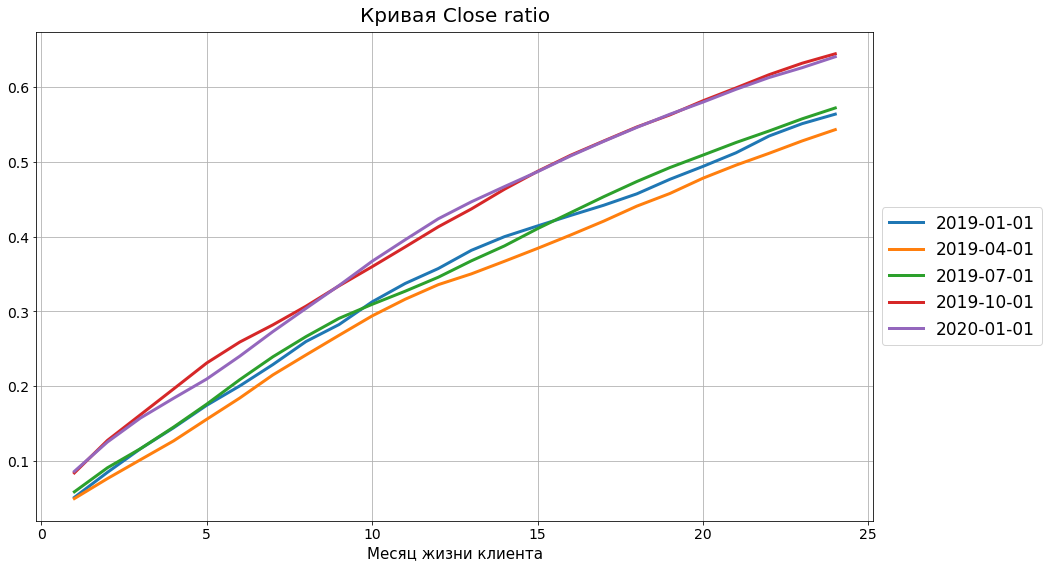

In [377]:
def plot_clo_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
        .agg({"clo_flg":np.mean})
        .rename(columns = {"clo_flg": 'close_ratio'})
        .unstack('gen_quarter_dt')
        ['close_ratio']
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
# Строим график при помощи pyplot
plot_clo_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

In [372]:
df['statement_num'] = df['statement_num'].apply(lambda x: int(x))

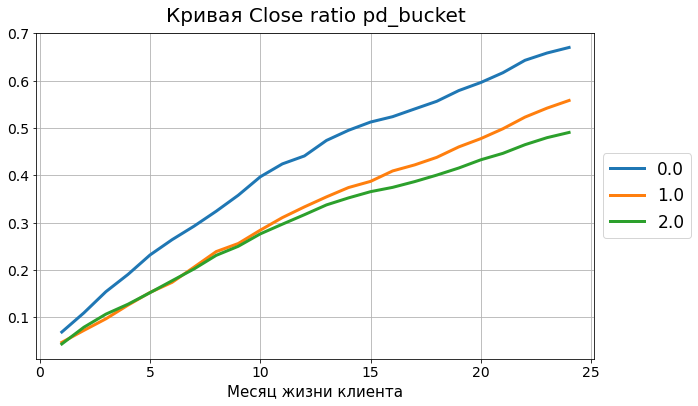

In [375]:
def plot_clo_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'close_ratio'})
            .unstack(bucket)
            ['close_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

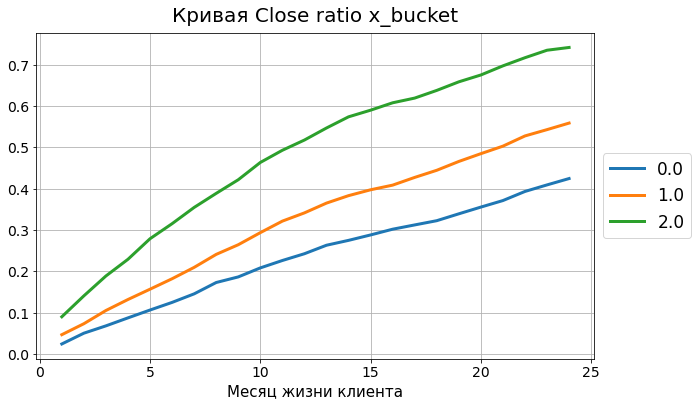

In [374]:
plot_clo_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close ratio x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: здесь укажи выбранную тобой переменную и обоснуй свой выбор
К моему удивлению x_bucket разделяет кривые наилучшим образом, это видно из графиков. На первом графике, прямые отстают друг от друга на расстоянии менее чем 0.1, а на втором графике наоборот, поэтому выбираем x_bucket

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

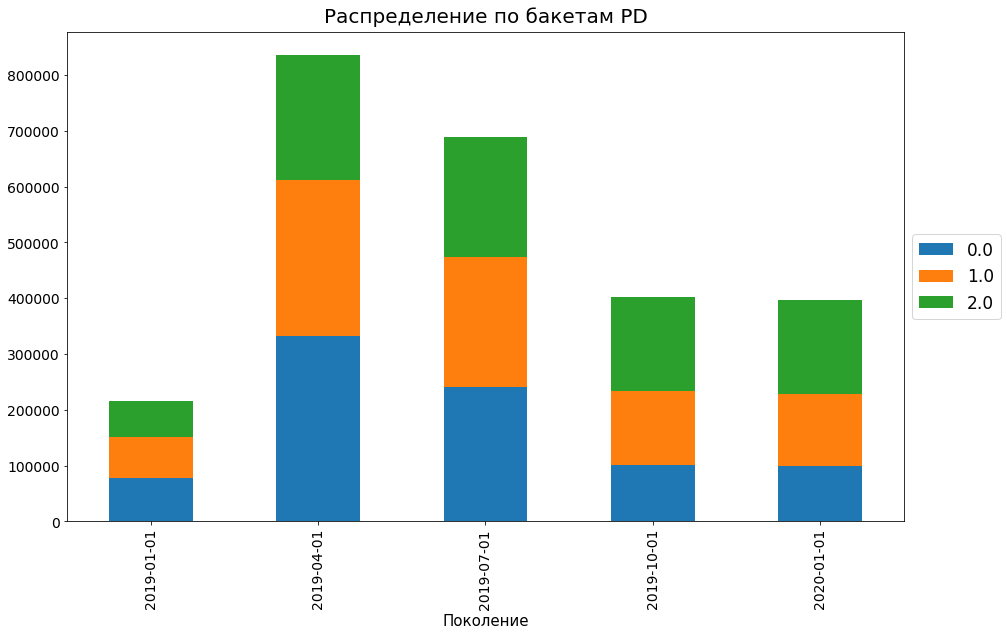

In [376]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')


plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

Мне кажется не нужно исключать никакие бакеты и поколения, потому что всё выглядит вполне себе адекватно. Смутить может разве, что первый столбец, но если посмотреть внимательно, то можно заметить , что в нем порядка 200000 наблюдений, что является достаточно большим числом и никак не испортит дальнейшую аналитику.

### Кривые СLO Rate в разбивке по бакетам 

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

Посчитаем значение Clo rate и отрисуем графики

In [378]:
%matplotlib inline
from ipywidgets import interactive
# Выгружаем таблицу c винтажами

close_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'pd_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('close_rate = clo_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_close_rate_by_generation(pd_bucket):
    
    cur_df = close_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['close_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Close rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_close_rate_by_generation, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_c…

#### Выводы: сделай выводы по полученным графикам
Из данных графиков можно заметить, что голубая кривая в первом бакете ведёт себя странным образом по сравнению с остальными, из-за своих сильных коллебаний. Поэтому от неё лучше избавиться. Такой результат мог быть получен, из-за того, в первом поколении меньше всего наблюдений, + мы разбили его на бакеты, и в первом бакете осталось совсем мало наблюдений, поэтому данная кривая может себя вести отличным образом от других. Также можно заметить , особую точку на всех графиках, можно увидеть сильный спад, после первой оплаты. Это связано с тем, что существует целая группа людей, которая беря кредит, гасит его на следующий месяц.
### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?
Из данных графиков можно заметить, что голубая кривая в первом бакете ведёт себя странным образом по сравнению с остальными, из-за своих сильных коллебаний. Поэтому от неё лучше избавиться. Такой результат мог быть получен, из-за того, в первом поколении меньше всего наблюдений, + мы разбили его на бакеты, и в первом бакете осталось совсем мало наблюдений, поэтому данная кривая может себя вести отличным образом от других. Также можно заметить , особую точку на всех графиках, можно увидеть сильный спад, после первой оплаты. Это связано с тем, что существует целая группа людей, которая беря кредит, гасит его на следующий месяц. Исключать эту точку не нужно, потому что она может нести в себе полезную информацию, а также не является выбросом



### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

Я выбрал построение средней кривой по среднему поколений, так как оно удобно тем, что компенсирует отклонения каждого поколения, поэтому даже если наши поколения отличаются, то кривая всё равно сможет уловить общую тенденцию.

In [379]:
# Исключаем "странные" поколения

exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (pd_bucket == 0)) '''
close_rate_data.query(exception_query, inplace = True)

# Считаем среднее

close_rate_mean = close_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'close_rate':np.mean})\
    .rename(columns = {'close_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_close_rate_mean(pd_bucket):
    vintages_graph = close_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['close_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (close_rate_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее'].plot(
        ax=vintages_graph,
        figsize=(15, 9),
        grid=True,
        lw=4,
        color='Black',
        ls='dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               fontsize='17')  # чтобы отобразить их вместе
    plt.title("Кривая Close rate, pd_bucket = " + str(pd_bucket),
              size=20,
              verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_close_rate_mean, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(1.0, 0.0, 2.0), value=1.0), Output()), _dom_c…

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

Рассмотрим сглаживания на примере одного бакета PD

Реализуем функцию линейного сглаживания

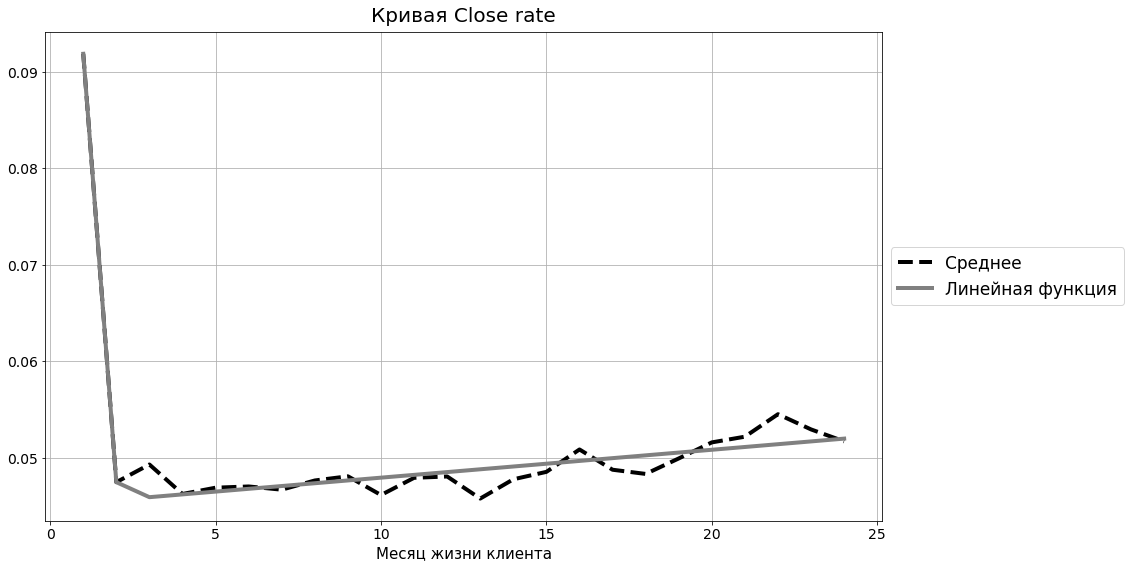

In [380]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = close_rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 3, 24)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Реализуем функцию полиномиального сглаживания

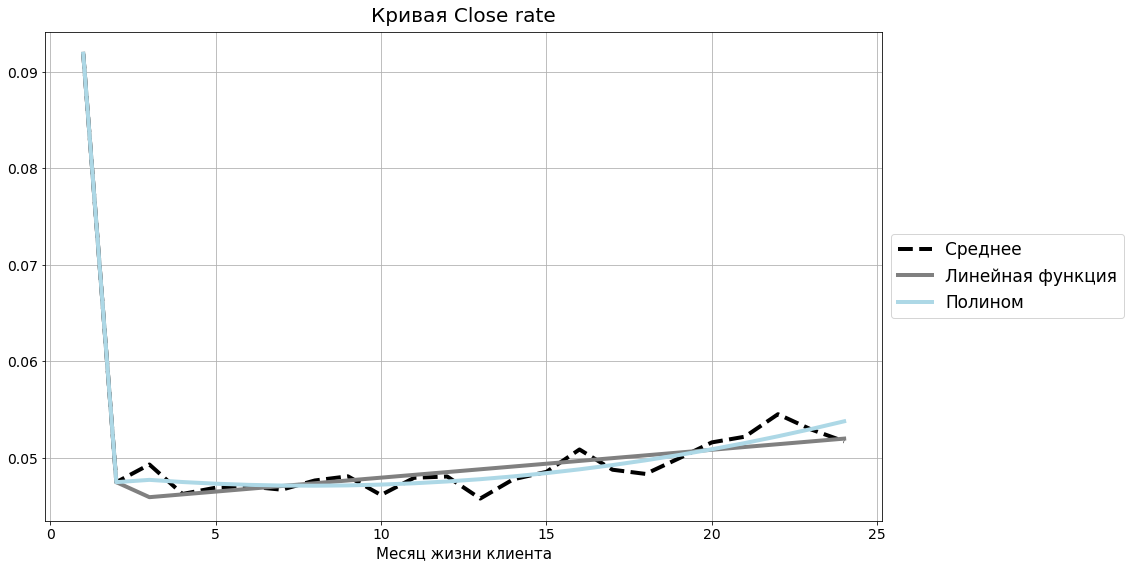

In [381]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 3,24,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Реализуем сглаживание Скользящим средним

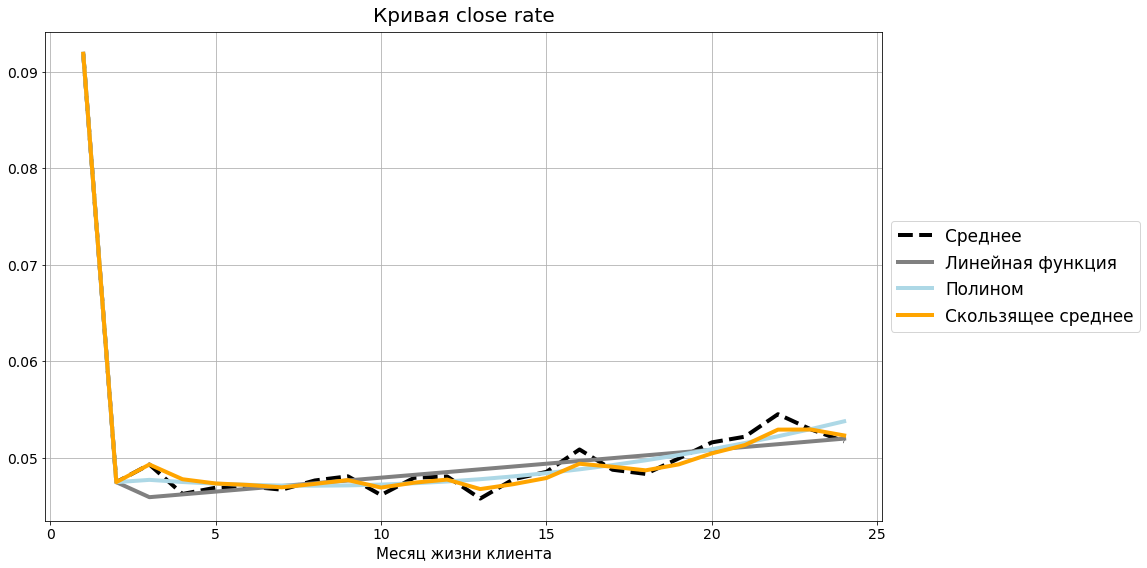

In [382]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 3,24, 0.5)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

Я остановился на полиномиальном сглаживании, из-за того что оно имеет явные преимущества на фоне линейного и скользящего сглаживания. Линейня функция – плохо приближает конец кривой, Скользящее среднее – подстраивается под незначимые колебания кривой, а полином выглядит идеальным вариантом на их фоне. Также я выделил точки, к которым не применят сглаживания, это точка после первого месяца. Можно увидеть сильный спад, после первой оплаты. Это связано с тем, что существует целая группа людей, которая беря кредит, гасит его на следующий месяц. По этому в любом случае эта точка будет всегда выделяться на фоне остальных

### Отрисуй сглаженные кривые по всем трем бакетам PD

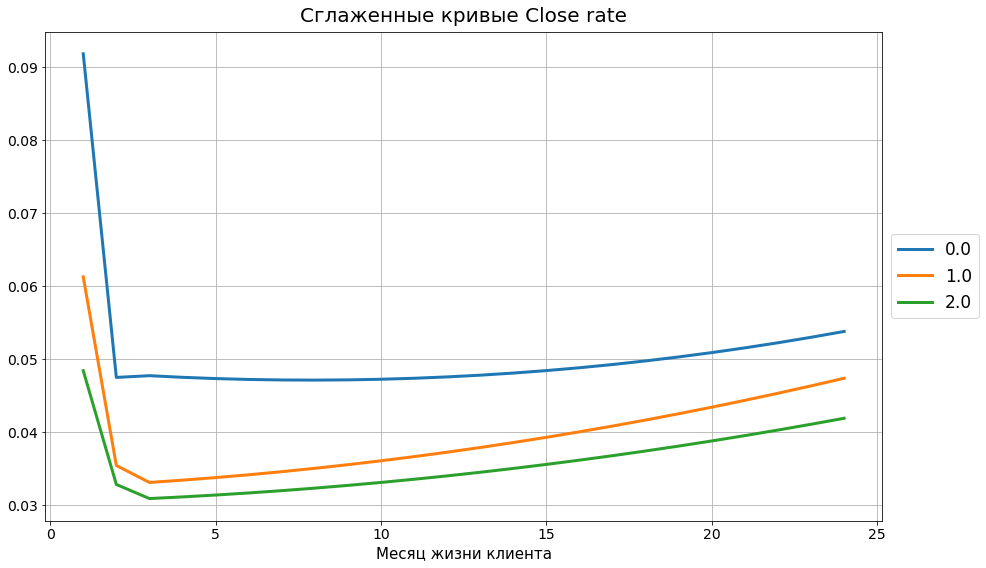

In [383]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = close_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 3,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## (Задача со звездочкой) 
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

Да, в CLO rate присутствуют последствия макроэкономического воздействия. Из графиков можно заметить, две пиковые точки, которые примерно соответствуют весне 2020 года и концу 2020 года. Из чего можно сделать предположение, что такого рода аномалии были получены из-за последствий Коронавируса, ведь именно на это время приходяться два самых сильных пика эпидемии. Но в тоже самое время второй пик, является верхней точкой, которая соответствует декабрю, поэтому , возможно, это точка была вызвана концом года и получением примий в большинстве компаний

## Задание 1

#### Функции, которые реализуют разложение матрицы

In [385]:
def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [390]:
df['gen_quarter_dt'] = pd.to_datetime(df['gen_quarter_dt'])
df['gen_month_dt'] = pd.to_datetime(df['gen_month_dt'])

In [449]:
df1 = df[df['gen_month_dt'] != pd.to_datetime('2019-02-01')]

#### Применим функцию к нашим данным

In [450]:
# Подготавливаем данные
df_rate = df1.eval('clo_new_flg = clo_flg * prev_act_flg',
                  inplace=False).groupby(
                      ["pd_bucket", "gen_month_dt", "statement_num"],
                      as_index=False).agg({
                          "clo_new_flg": np.sum,
                          "prev_act_flg": np.sum,
                          "user_id": np.count_nonzero
                      }).rename(columns=({
                          "clo_new_flg": 'clo_cnt',
                          "prev_act_flg": 'prev_act_cnt',
                          "user_id": "cnt"
                      })).eval('close_rate = clo_cnt / prev_act_cnt',
                               inplace=False)

# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(df_rate,
                    generation='gen_month_dt',
                    group='pd_bucket',
                    statement_num='statement_num',
                    feature='close_rate')

/Users/kirillgolubev/PycharmProjects/DeepLearningOnFingers/venv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  warnings.warn(


pd_bucket = 0.0
Initial 0.850502
0  0.239381
1  0.224815
2  0.223456
3  0.222733
4  0.222339
5  0.221826
6  0.221802
7  0.221205
8  0.221006
9  0.219421
10  0.218841
11  0.215700
12  0.214469
13  0.208046
14  0.204650
15  0.183912
16  0.166390
17  0.107172
18  0.087861
19  0.075289
20  0.068644
21  0.065573
22  0.063077
23  0.063011
24  0.062655
25  0.062560
26  0.062301
27  0.062212
28  0.061226
29  0.060829
30  0.056962
31  0.055880
32  0.047965
33  0.046073
34  0.037663
35  0.035644
36  0.030562
37  0.030309
38  0.030198
39  0.030129
40  0.029914
41  0.029854
42  0.029576
43  0.029558
44  0.029548
45  0.029542
46  0.029539
47  0.029537
48  0.029535
49  0.029534
50  0.029534
51  0.029534
52  0.029533
53  0.029533
54  0.029533
55  0.029533
56  0.029533
57  0.029533
pd_bucket = 1.0
Initial 0.542320
58  0.184126
59  0.172336
60  0.171308
61  0.170765
62  0.170468
63  0.170303
64  0.170071
65  0.170057
66  0.169638
67  0.169502
68  0.168523
69  0.168169
70  0.166388
71  0.165645
72  0.16

## Задание 2

#### Получившиеся кривые внешних воздействий

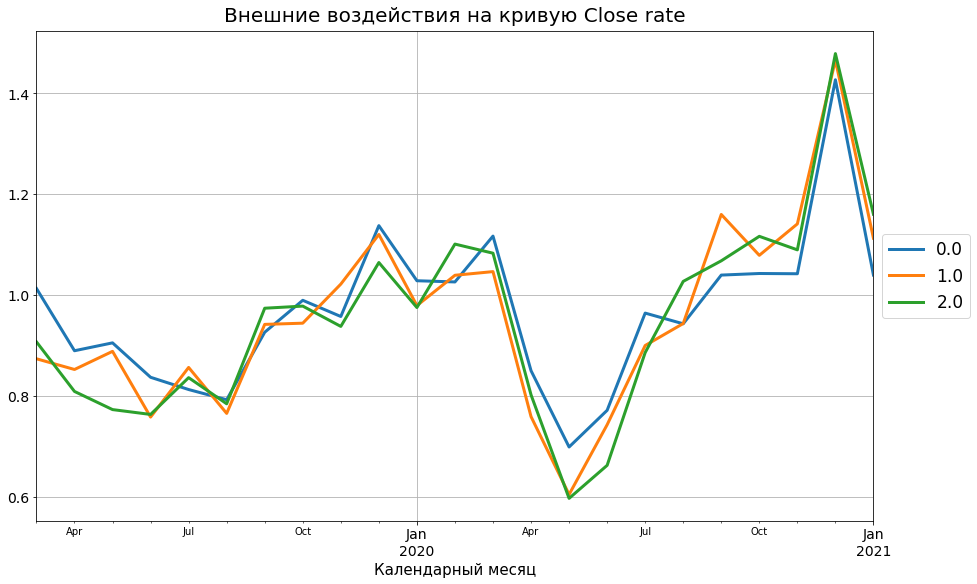

In [434]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Кривые Close rate, вычищенные от внешних воздействий

/var/folders/4c/gl255b9x76z020j9qvyqkbc00000gn/T/ipykernel_2650/2211584874.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)


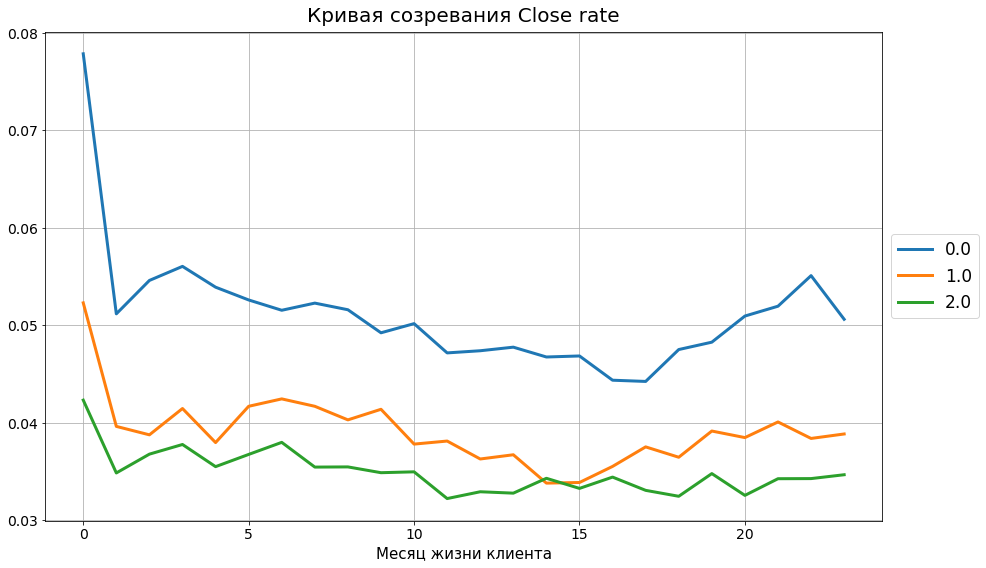

In [435]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## Задание 3

#### Вычищенные кривые в разбивке по бакетам и поколениям 

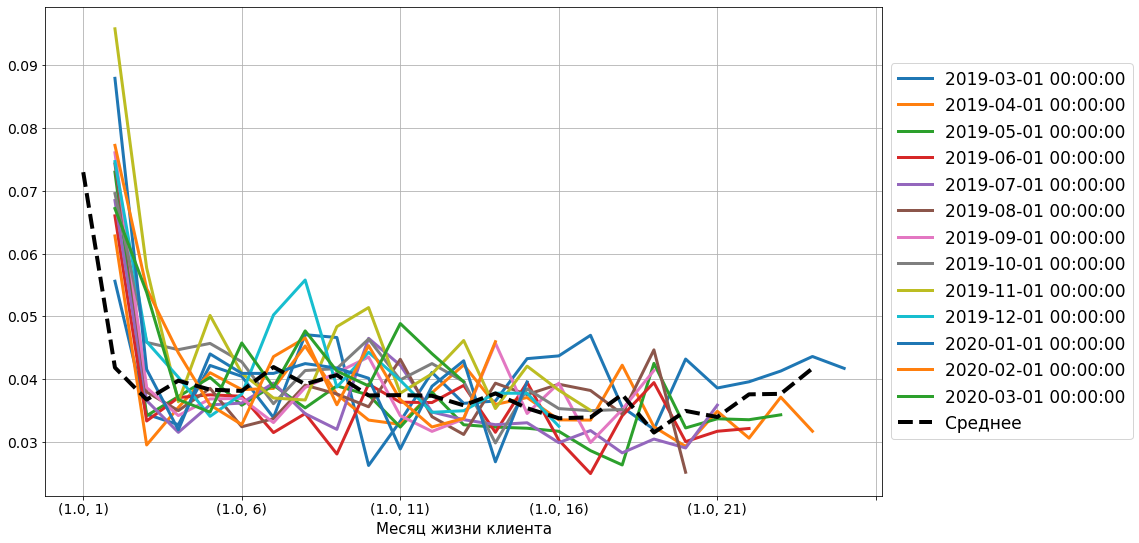

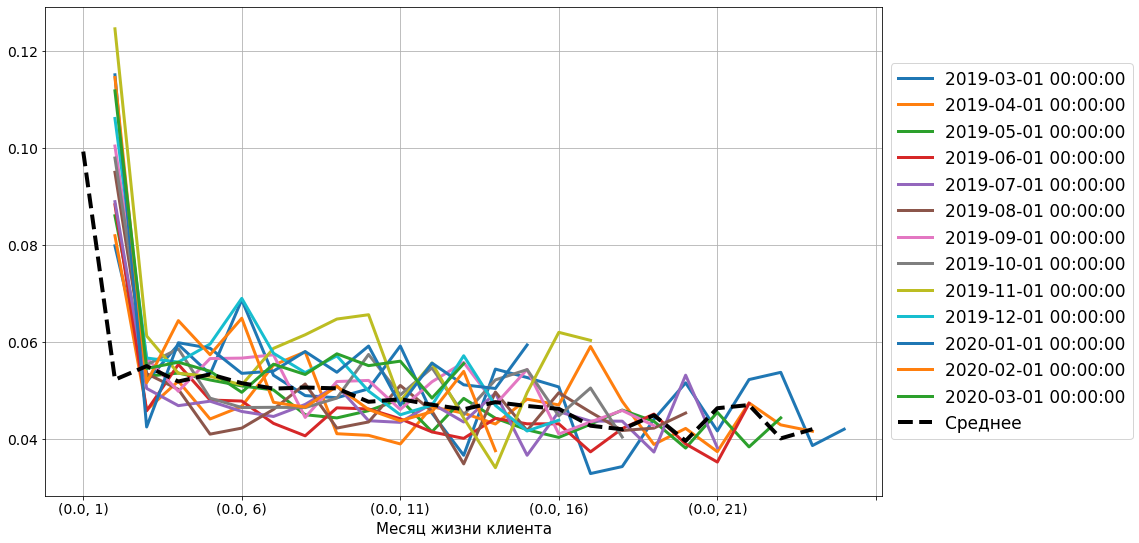

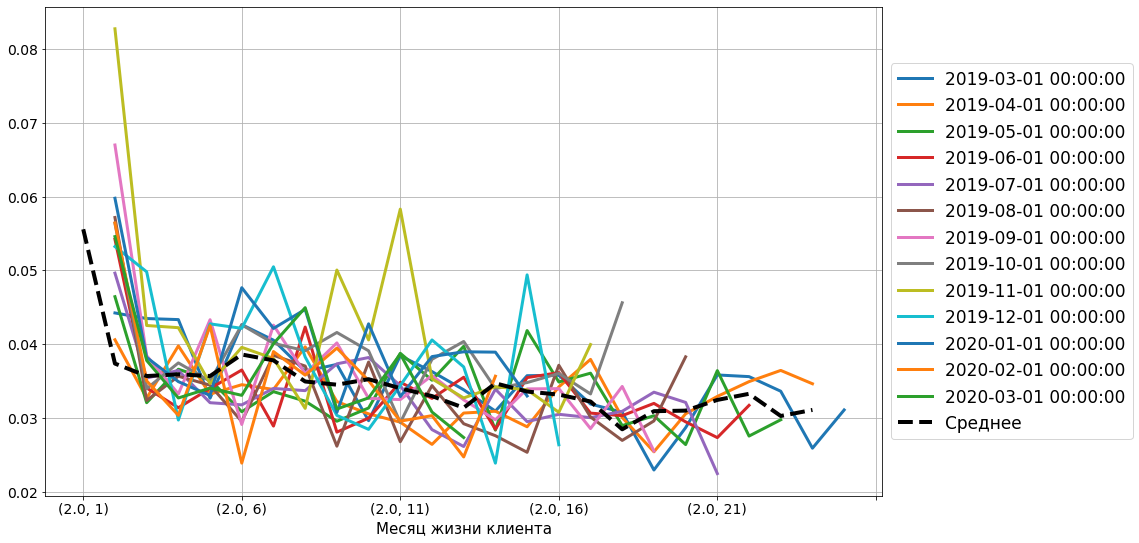

In [451]:
# Считаем среднее

close_rate_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_close_rate_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (close_rate_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_close_rate_mean(i)

## Задание4

### Найдем лучшую функцию для сглаживания кривых

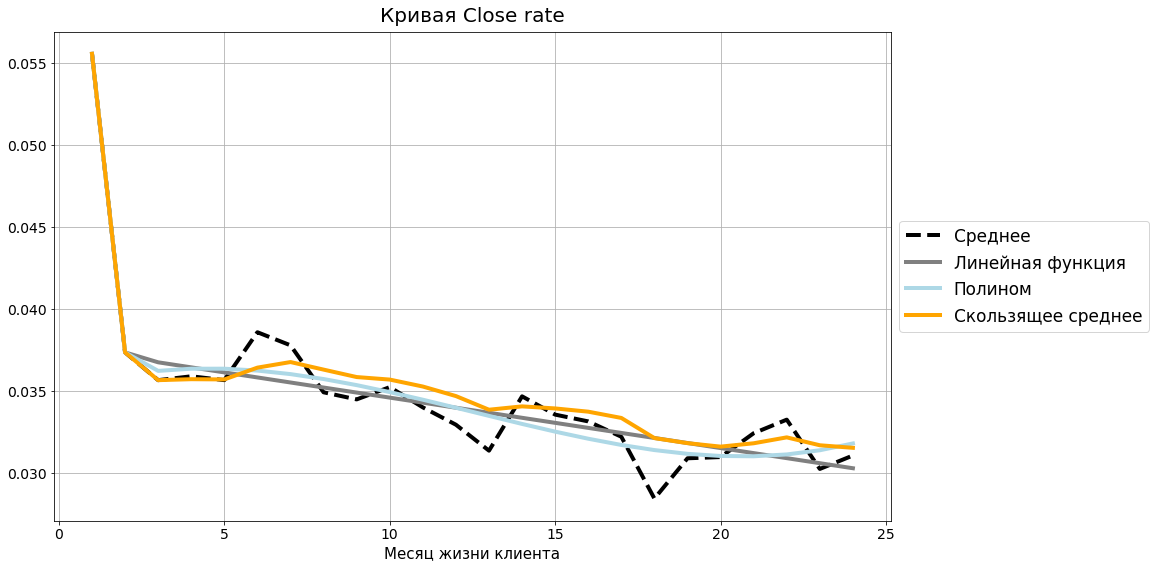

In [459]:
df_linear = close_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 3, 24)
df_polynom = polynom_approximation(df_linear, 3,24,3)
df_smooth = exponential_smoothing(df_polynom, 3,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Для приближения воспользуемся полиномом и сгладим все кривые
Я выбрал полином из тех же сообрадений, что и в задании из первой части

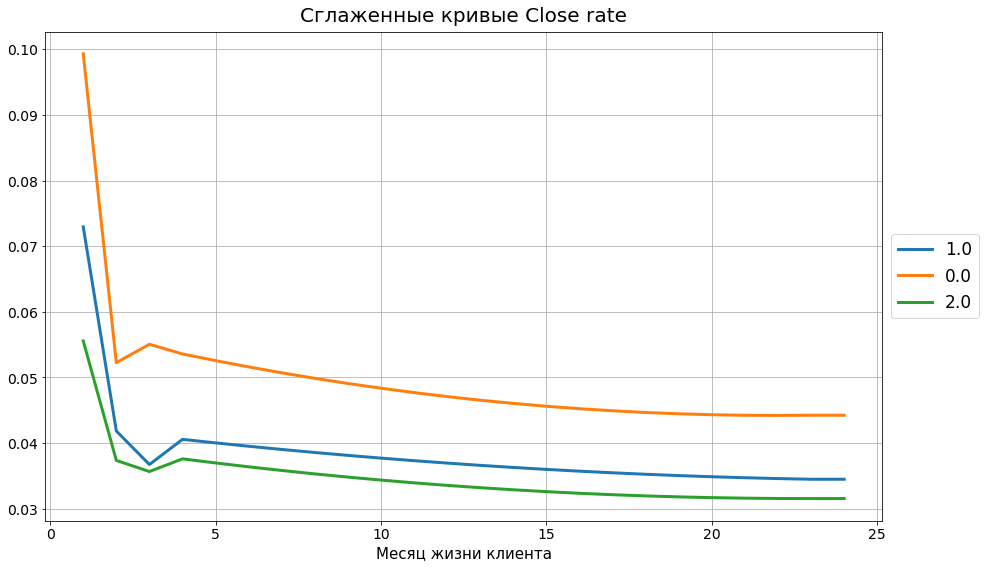

In [460]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df1['pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = close_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,22,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Close rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)